## Selección del cluster
En este notebook queremos explorar la selección del cluster utilizando análisis del DR2 y el uso de eliminación del outliers.

## Requirements

In [4]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from dotenv import load_dotenv
from tqdm import tqdm
from google.cloud import storage

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project, ProjectDontExist

load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Resultados Previos
Resultados en el DR2 en el trabajo [Baumgardt et al., 2019](https://drive.google.com/file/d/1VtDW8WacV4sDh1wr_FGPmesjclg6zdbZ/view)

In [5]:
v = Vizier(columns=["Name", "Rsun", "e_Rsun", "pmRA*", "e_pmRA*", "pmDE", "e_pmDE", "RV", "e_RV", "rho"])
v.ROW_LIMIT = -1
catalogs = v.get_catalogs("J/MNRAS/482/5138")
clusters_dr2 = catalogs[0].to_pandas()
clusters_dr2.Name = clusters_dr2.Name.str.lower()

clusters_dr2["parallax"] = 1 / (clusters_dr2.Rsun)
clusters_dr2["e_parallax"] = (1 / (clusters_dr2.Rsun - clusters_dr2.e_Rsun) - 1 / (clusters_dr2.Rsun + clusters_dr2.e_Rsun)) / 2
clusters_dr2 = clusters_dr2[["Name","parallax", "e_parallax", "pmRA_", "e_pmRA_", "pmDE", "e_pmDE", "RV", "e_RV", "rho", "Rsun", "e_Rsun"]]
clusters_dr2 = clusters_dr2.rename(columns=dict(zip(["parallax", "pmRA_", "pmDE", "e_parallax", "e_pmRA_", "e_pmDE"], ["parallax", "pmra", "pmdec", "e_parallax", "e_pmra", "e_pmdec"])))
clusters_dr2

,Name,parallax,e_parallax,pmra,e_pmra,pmdec,e_pmdec,RV,e_RV,rho,Rsun,e_Rsun
0,ngc 104,0.225734,0.002038,5.25,0.01,-2.53,0.01,-17.209999,0.18,0.04,4.430000,0.04
1,ngc 288,0.100200,0.003317,4.22,0.01,-5.65,0.01,-44.830002,0.13,0.31,9.980000,0.33
2,ngc 362,0.109051,0.003094,6.71,0.01,-2.51,0.01,223.259995,0.28,-0.09,9.170000,0.26
3,whiting 1,0.031949,NaN,-0.04,0.12,-1.78,0.08,-130.410004,1.79,-0.09,31.299999,NaN
4,ngc 1261,0.064558,NaN,1.61,0.02,-2.05,0.02,71.360001,0.24,0.19,15.490000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
149,ngc 7089,0.095147,0.003354,3.51,0.01,-2.16,0.01,-3.720000,0.34,0.01,10.510000,0.37
150,ngc 7099,0.125000,0.008952,-0.73,0.01,-7.24,0.01,-185.190002,0.17,0.53,8.000000,0.57
151,pal 12,0.052632,NaN,-3.28,0.03,-3.31,0.03,27.910000,0.28,0.33,19.000000,NaN
152,pal 13,0.040323,NaN,1.64,0.09,0.25,0.07,25.870001,0.27,0.04,24.799999,NaN


## Resultados DR3

In [7]:
CLUSTER_NAME = "ngc 104"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
print(str(project))

Las muestras analizadas de ngc 104 son:
Muestras seleccionadas del objeto astronómico ngc 104 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 84612.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 16654.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16654.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 24557.

Muestras seleccionadas del objeto astronómico ngc 104 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 5444.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1898.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 1898.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2370.

Se han encontrado 37 fuentes de rayos X.
Estimated number of clusters: 3
Estimated number of noise points: 2419
	 - Volumen total del cluster 0: 1302.
	 - Volumen

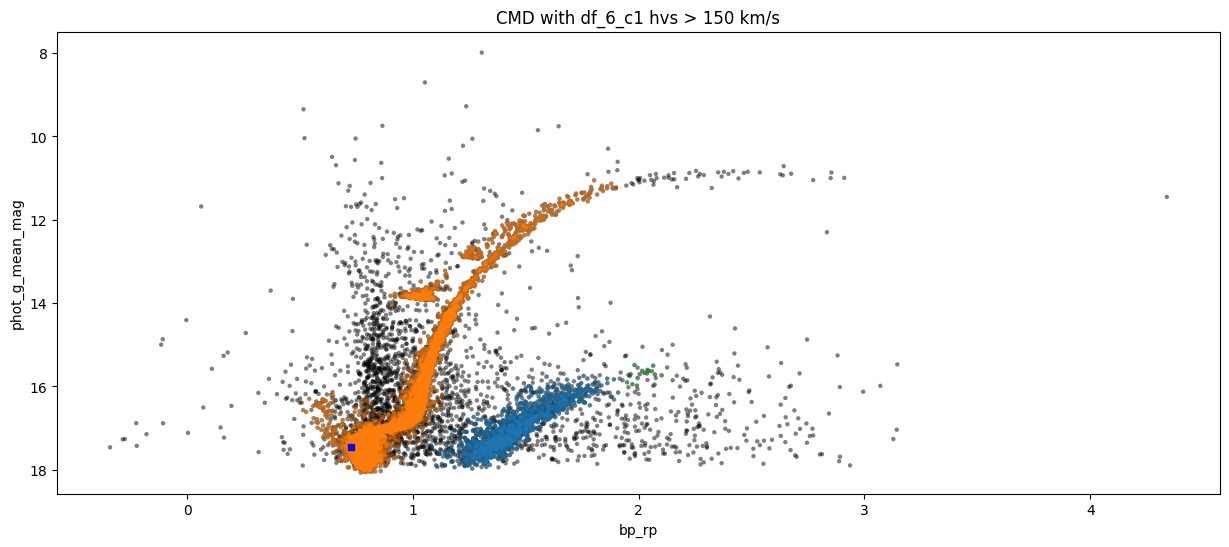

In [56]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False
)

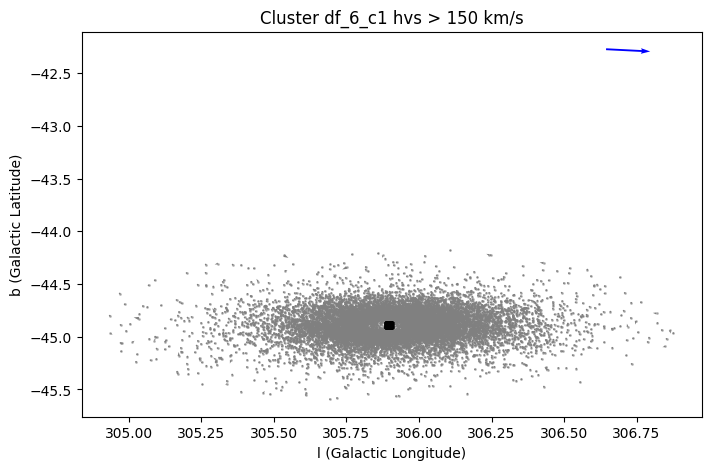

In [57]:
fig, ax = project.plot_cluster(hvs_candidates_name="df_6_c1", factor_sigma=1, hvs_pm=150, legend=False, factor_size=50)

In [58]:
df_hvs_candidates = project.get_data("df_6_c1")
selected = project.clustering_results.selected_hvs(df_hvs_candidates, 1, 150)
selected["pm_kms"] - project.clustering_results.gc.pm_kms.mean()

1580    173.520025
Name: pm_kms, dtype: float64

In [59]:
gc = project.clustering_results.gc
display(gc[["pmra", "pmdec", "parallax","pmra_kms", "pmdec_kms", "radial_velocity"]].describe())

,pmra,pmdec,parallax,pmra_kms,pmdec_kms,radial_velocity
count,12797.000000,12797.000000,12797.000000,1.279700e+04,1.279700e+04,1125.000000
mean,5.251557,-2.574233,0.195411,-4.464373e+01,2.204548e+01,-17.202012
std,0.374576,0.384599,0.077816,2.152303e+04,1.079181e+04,10.794205
min,3.059615,-4.270577,-0.227476,-2.425692e+06,-6.899552e+04,-119.478880
25%,5.006763,-2.840394,0.153701,1.032943e+02,-7.913944e+01,-22.466637
50%,5.249858,-2.579028,0.195637,1.258702e+02,-6.180249e+01,-17.118820
75%,5.493504,-2.306996,0.235677,1.600447e+02,-4.942705e+01,-12.428101
max,7.347773,-0.871430,0.564312,1.239166e+05,1.217126e+06,98.392784


### Reclustering

In [8]:
data_name = "df_1_c2"

if project.get_data(data_name).shape[0] < 16000:
    data_name = "df_1_c0"

columns_to_clus=["ra", "dec", "pmra", "pmdec", "parallax_corrected"]
columns=["pmra", "pmdec", "parallax_corrected"]

reference_cluster = clusters_dr2[clusters_dr2.Name == project.astro_object.name].iloc[0]
clustering = project.cluster_detection(
    data_name=data_name,
    columns=columns, 
    columns_to_clus=columns_to_clus,
    max_cluster=10,
    method="dbscan",
    n_trials=100,
    reference_cluster=reference_cluster
    #params_to_opt=params_distribution
)

[I 2025-05-20 14:38:10,237] A new study created in memory with name: no-name-435b5124-a2d7-421d-bf94-7e1a5cd5d7ef
[I 2025-05-20 14:38:12,060] Trial 0 finished with value: 0.7864710919555938 and parameters: {'eps': 0.643449260047385, 'min_samples': 6, 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 0 with value: 0.7864710919555938.
[I 2025-05-20 14:38:15,164] Trial 1 finished with value: 3.230968409852971 and parameters: {'eps': 0.8429380912263668, 'min_samples': 7, 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with value: 0.7864710919555938.
[I 2025-05-20 14:38:16,254] Trial 2 finished with value: 17.283757496456047 and parameters: {'eps': 0.8214836555087447, 'min_samples': 4, 'metric': 'l2', 'algorithm': 'brute'}. Best is trial 0 with value: 0.7864710919555938.
[I 2025-05-20 14:38:16,979] Trial 3 finished with value: 18.29222663171956 and parameters: {'eps': 0.2974137099804978, 'min_samples': 9, 'metric': 'cityblock', 'algorithm': 'brute'}. Best is trial 0 wi

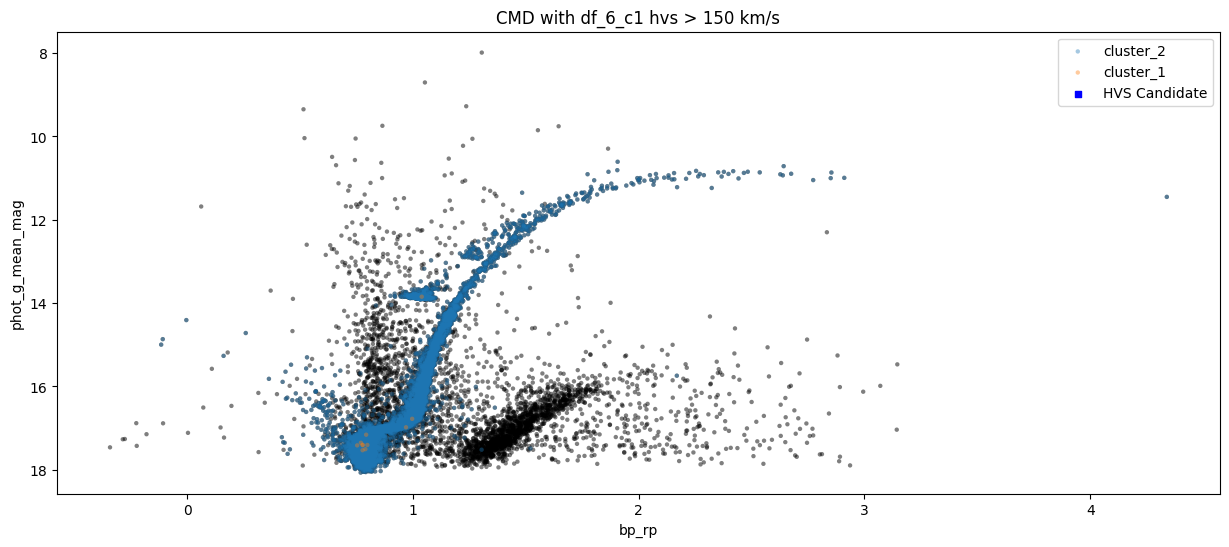

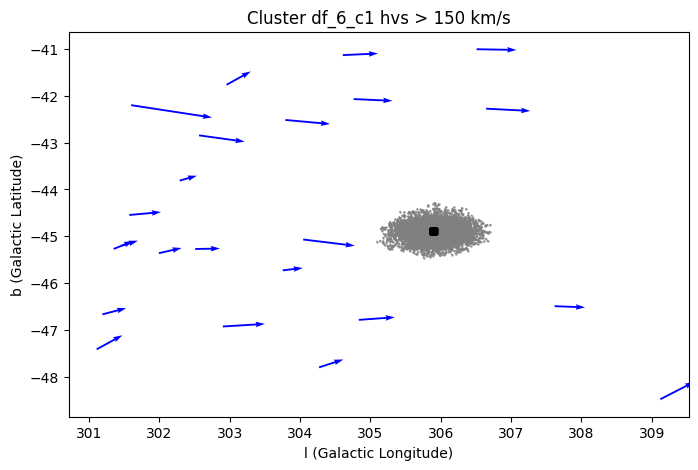

In [31]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 0,
            hvs_pm = 150,
            legend=True,
            clusters=[2,1]
)

fig, ax = project.plot_cluster(hvs_candidates_name="df_6_c1", factor_sigma=1, hvs_pm=150, legend=False, factor_size=50)

In [10]:
project.clustering_results.get_labels(return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 1191,    11, 12885,     8,     8,     9]))

In [11]:
project.clustering_results.main_label

2

In [25]:
project.clustering_results.set_main_label(1)
gc = project.clustering_results.gc
display(gc[columns_to_clus].describe())

,ra,dec,pmra,pmdec,parallax_corrected
count,11.000000,11.000000,11.000000,11.000000,11.000000
mean,7.205543,-72.512662,5.339172,-2.371450,0.223359
std,0.108311,0.025243,0.155686,0.082510,0.072031
min,6.979590,-72.558820,4.972189,-2.537478,0.057920
25%,7.156120,-72.520144,5.280572,-2.403219,0.189388
50%,7.188375,-72.512630,5.362677,-2.380277,0.225804
75%,7.285536,-72.504573,5.408742,-2.308124,0.268066
max,7.378670,-72.462654,5.598316,-2.244588,0.337054


In [29]:
project.clustering_results.set_main_label(2)
gc = project.clustering_results.gc
display(gc[columns_to_clus].describe())

,ra,dec,pmra,pmdec,parallax_corrected
count,12885.000000,12885.000000,12885.000000,12885.000000,12885.000000
mean,5.968152,-72.077565,5.252672,-2.575162,0.225188
std,0.492989,0.144517,0.375189,0.386780,0.078844
min,4.104718,-72.669672,3.722795,-4.270577,-0.219424
25%,5.661589,-72.174645,5.004273,-2.842956,0.183724
50%,5.950746,-72.080471,5.249675,-2.580997,0.226131
75%,6.293008,-71.985319,5.497619,-2.306368,0.264487
max,7.931797,-71.535089,7.333937,-1.048327,0.673958


In [137]:
project.save_project(to_zip=True)

client = storage.Client(project=os.getenv("PROJECT_ID"))
bucket = client.bucket(os.getenv("BUCKET"))
blob_path = project.astro_object.name+".zip"
path_zip = os.path.join(project.path, blob_path)

blob = bucket.blob(blob_path)
blob.upload_from_filename(path_zip)

In [169]:
gc = project.clustering_results.gc
gc

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,pmra_kms,pmdec_kms,pm_kms,pm_l,pm_b,uwe,parallax_corrected
1001,1636148068921376768,Gaia DR3 5889480506022883072,5889480506022883072,260888290,2016.0,233.962483,0.190277,-50.676717,0.152289,0.079013,...,NaN,NaN,NaN,-320.686964,-93.412417,334.014983,-5.519052,0.701082,1.046436,0.098583
1462,1636148068921376768,Gaia DR3 5889481498152007808,5889481498152007808,945854046,2016.0,233.894528,0.088074,-50.714211,0.076667,0.199664,...,0.7146,0.7602,MARCS,-126.114248,-44.774525,133.826610,-5.619480,0.386374,1.030332,0.225932
1469,1636148068921376768,Gaia DR3 5889481502455239552,5889481502455239552,1085040349,2016.0,233.885622,0.207612,-50.707696,0.175306,0.038465,...,NaN,NaN,NaN,-633.539110,-207.146572,666.544452,-5.380971,0.506156,1.079188,0.056130
1521,1636148068921376768,Gaia DR3 5889481601221785984,5889481601221785984,1582683425,2016.0,233.812336,0.056694,-50.721775,0.048571,0.127004,...,1.2722,1.3251,PHOENIX,-199.055835,-59.728367,207.823731,-5.525142,0.656623,0.918126,0.157782
1526,1636148068921376768,Gaia DR3 5889481601227796992,5889481601227796992,448610845,2016.0,233.820258,0.089245,-50.714547,0.075245,0.052316,...,0.7386,0.7971,MARCS,-499.832159,-132.482095,517.091571,-5.638044,0.856161,1.070971,0.079350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,1636148068921376768,Gaia DR3 5889483735838874880,5889483735838874880,57716605,2016.0,233.926895,0.064335,-50.636325,0.051881,0.098304,...,1.0672,1.1103,PHOENIX,-247.875650,-87.119813,262.739795,-5.430703,0.390695,1.055110,0.128485
3303,1636148068921376768,Gaia DR3 5889483735886097408,5889483735886097408,193851095,2016.0,233.910338,0.171559,-50.638166,0.131270,0.334930,...,0.0031,0.0255,PHOENIX,-75.933816,-28.054754,80.950686,-5.706553,0.319275,1.041852,0.362152
3713,1636148068921376768,Gaia DR3 5889484560472928384,5889484560472928384,528056514,2016.0,233.888112,0.120675,-50.618538,0.089879,0.157529,...,0.0007,0.0079,PHOENIX,-159.671013,-51.593712,167.799712,-5.545889,0.541118,1.021690,0.183016
3726,1636148068921376768,Gaia DR3 5889484560519874176,5889484560519874176,750125394,2016.0,233.889821,0.019563,-50.616143,0.017209,0.083702,...,NaN,NaN,NaN,-304.650995,-95.762924,319.347407,-5.603613,0.591918,1.003607,0.127218


In [172]:
data.shape[0]

383

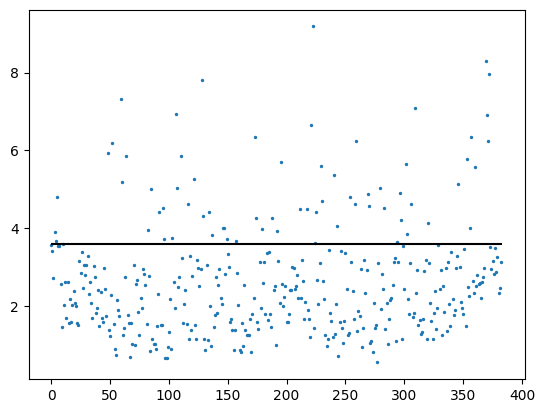

In [220]:
from sklearn.metrics import pairwise_distances
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

data = StandardScaler().fit_transform(gc[columns_to_clus])
cov = MinCovDet(random_state=0).fit(data)


mu = cov.location_
s = cov.covariance_
sinv = np.linalg.inv(s)


dm = pairwise_distances(data, mu.reshape(1,-1), metric="mahalanobis", VI=sinv)

fig, ax = plt.subplots(1,1)
cutoff = np.sqrt(chi2.ppf(0.975, df=data.shape[1]))

ax.scatter(np.arange(data.shape[0]), dm, s=2)
ax.hlines(cutoff, 0, dm.size, color="k")

In [230]:
from sklearn.ensemble import IsolationForest

if_model = IsolationForest()
labels = if_model.fit_predict(gc[columns_to_clus])

In [242]:
from scipy.stats import shapiro

gc[columns_to_clus].apply(lambda x: shapiro(x))

,ra,dec,pmra,pmdec,parallax_corrected
0,0.992586,0.986857,9.331541e-01,9.437615e-01,0.983926
1,0.054586,0.001530,4.430513e-12,7.107507e-11,0.000291


(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         3.986e+03, 1.358e+03, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         3.941e+03, 1.403e+03, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.200e+01,
         4.624e+03, 7.050e+02, 0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.200e+01,
         4.701e+03, 6.160e+02, 2.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         4.583e+03, 7.450e+02, 1.400e+01, 2.000e+00]]),
 array([-35.22736387, -30.08865161, -24.94993935, -19.81122708,
        -14.67251482,  -9.53380256,  -4.39509029,   0.74362197,
          5.88233423,  11.0210465 ,  16.15975876]),
 <a list of 5 BarContainer objects>)

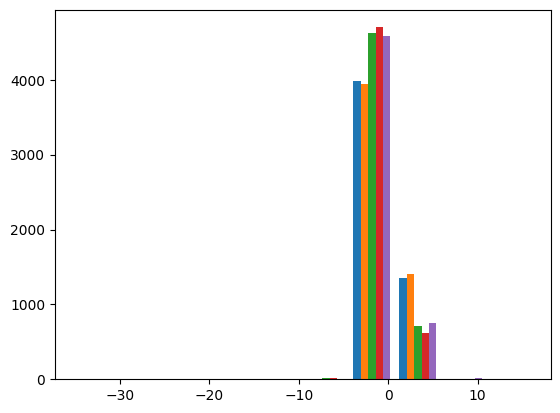

In [227]:
data_star[columns_to_clus].hist()

In [236]:
gc.loc[dm[:,0] <= cutoff, columns].describe()

,pmra,pmdec,parallax_corrected
count,315.000000,315.000000,315.000000
mean,-5.324308,-1.647525,0.130869
std,0.191324,0.179620,0.146306
min,-5.834781,-2.176810,-0.276135
25%,-5.437734,-1.744291,0.055935
50%,-5.334331,-1.651387,0.128485
75%,-5.203191,-1.551794,0.211997
max,-4.813859,-1.157888,0.557928


In [240]:
gc.loc[labels==1, columns].describe()

,pmra,pmdec,parallax_corrected
count,332.000000,332.000000,332.000000
mean,-5.324244,-1.666369,0.132237
std,0.223837,0.220102,0.152343
min,-6.016588,-2.436940,-0.288510
25%,-5.444455,-1.765689,0.053155
50%,-5.334947,-1.654959,0.128849
75%,-5.200457,-1.548128,0.219551
max,-4.298667,-1.080572,0.557928


In [237]:
gc.loc[:, columns].describe()

,pmra,pmdec,parallax_corrected
count,383.000000,383.000000,383.000000
mean,-5.335925,-1.687897,0.137530
std,0.318288,0.290626,0.171868
min,-6.665460,-2.952416,-0.368611
25%,-5.466017,-1.803859,0.048601
50%,-5.335797,-1.659648,0.132507
75%,-5.175670,-1.535223,0.244866
max,-3.926354,-0.861084,0.562496


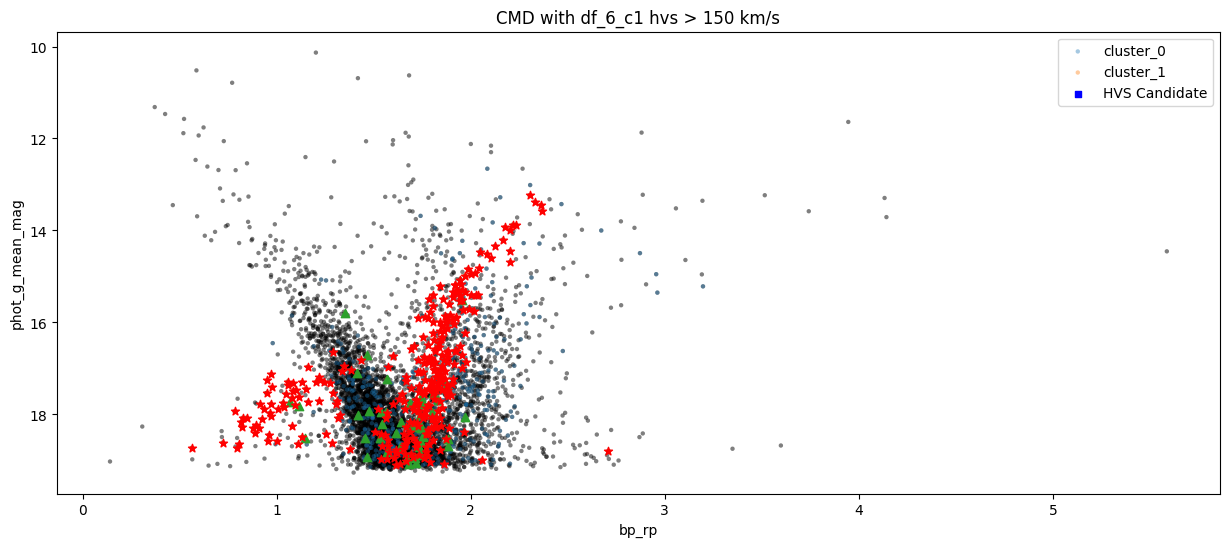

In [235]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 0,
            hvs_pm = 150,
            legend=True,
            clusters=None
)
if_model = IsolationForest()
labels = if_model.fit_predict(gc[columns_to_clus])

gc_selected = gc.loc[dm[:,0] <= cutoff, :]
gc_not_selected = gc.loc[dm[:,0] > cutoff, :]

gc_selected = gc.loc[labels==1, :]
gc_not_selected = gc.loc[labels==-1, :]

ax.scatter(gc_not_selected["bp_rp"], gc_not_selected["phot_g_mean_mag"], marker="^")
ax.scatter(gc_selected["bp_rp"], gc_selected["phot_g_mean_mag"], marker="*", color="r")